## Project 3-6-3 Amazon Reviews

Use one of the following datasets to perform sentiment analysis on the given Amazon reviews. Pick one of the "small" datasets that is a reasonable size for your computer. The goal is to create a model to algorithmically predict if a review is positive or negative just based on its text. Try to see how these reviews compare across categories. Does a review classification model for one category work for another?

http://jmcauley.ucsd.edu/data/amazon/

In [42]:
import json
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [23]:
jsonfile = 'reviews_Tools_and_Home_Improvement_5.json'

import pandas as pd

# read the entire file into a python array
with open(jsonfile, 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.decode("utf-8").rstrip('\n'), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)

In [16]:
data_df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,104800001X,"[0, 1]",5,"I hate it when my shirt collars, not otherwise...","01 29, 2014",A4IL0CLL27Q33,D. Brennan,Perfect for collar stay management,1390953600
1,104800001X,"[0, 0]",5,These little magnets are really powerful for t...,"05 31, 2013",A3Q5W5E7TDVLJF,funnyc130,Neat,1369958400
2,104800001X,"[0, 0]",5,I wanted something this small to mount on the ...,"03 13, 2013",A37KNOJXE2FU6,Joseph Yonke II,Very small and thin,1363132800
3,104800001X,"[0, 0]",5,I use these to magnetize my Warhammer 40K mini...,"06 16, 2013",A3U4AFML9SZPWK,"Leith Tussing ""I like tacos.""",Excellent hobby magnets,1371340800
4,104800001X,"[23, 25]",5,They are soo freaking annoying!! Why?! You sp...,"08 9, 2013",A36Y7X194VWVKA,Mark D.,They're annoying... which is why they get five...,1376006400


In [24]:
data_df['target'] = [1 if overall>3 else 0 for overall in data_df.overall]

In [33]:
X = data_df.loc[:, ~data_df.columns.isin(['asin', 'reviewerID', 'reviewerName', 'unixReviewTime', 'reviewTime', 'unixReviewTime', 'overall', 'target'])]
Y = data_df['target']


In [34]:
X_test, X_train, y_test, y_train = train_test_split(X, Y)

In [27]:
def get_wordcounts(text, vectorizer=None):
    """
    Takes a string or list of strings and returns term frequencies for each word in
    a vectorizer's vocabulary. If no vectorizer is passed, the vocabulary will be generated
    from the input text's unigrams and bigrams.
    """
    if vectorizer is None:
        vectorizer = CountVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
        vectorizer.fit(text)
    term_counts = zip(vectorizer.get_feature_names(),
        np.asarray(vectorizer.transform(text).sum(axis=0)).ravel())
    return sorted(term_counts, key=lambda x: x[1], reverse=True)

def get_tfidf_weights(text, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
        vectorizer.fit(text)
    tfidf_weights = zip(vectorizer.get_feature_names(),
        np.asarray(vectorizer.transform(text).sum(axis=0)).ravel())
    return sorted(tfidf_weights, key=lambda x: x[1], reverse=True)

In [43]:
amz_df_train = pd.DataFrame({'reviewText': X_train.reviewText, 'summary':X_train.summary, 'target':y_train})

amz_df_pos = amz_df_train[(amz_df_train.target == 1)]
amz_df_neg = amz_df_train[(amz_df_train.target == 0)]

In [78]:
num_words = 40

def get_tfidf(text):
    tfidf_vec = TfidfVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
    tfidf_vec.fit(text)

    train_tfidf = get_tfidf_weights(text, tfidf_vec)[:num_words]
    return train_tfidf

def get_counts(text):
    count_vec = CountVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
    
    count_vec.fit(text)
    train_counts = get_wordcounts(text, count_vec)[:num_words]
    return train_counts

In [79]:
pos_words = [word_score[0] for word_score in get_tfidf(amz_df_pos.summary)]
print(len(pos_words))
neg_words = [word_score[0] for word_score in get_tfidf(amz_df_neg.summary)]
print(len(neg_words))
neg_words2 = [word_score[0] for word_score in get_counts(amz_df_neg.summary)]
neg_words = list(set(neg_words + neg_words2))
print(len(neg_words))

pos_words = [word for word in pos_words if word not in neg_words]   
print(len(pos_words))

40
40
44
19


In [80]:
d = {word:[] for word in pos_words}

for word in d.keys():
    d[word]= [1 if word in comment.lower() else 0 for comment in amz_df_train.summary]
    
df_train = pd.DataFrame(d)
df_train['target'] = amz_df_train.target

In [81]:
print(len(df_train[df_train.target == 1]), len(df_train))

7124 33619


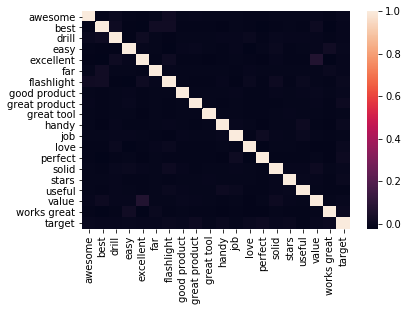

In [82]:
sns.heatmap(df_train.corr())

In [83]:
df_train = df_train.dropna()

In [84]:
d = {word:[] for word in pos_words}
for word in d.keys():
    d[word]= [1 if word in comment.lower() else 0 for comment in X_test.summary]
    
df_test = pd.DataFrame(d)
df_test['target'] = y_test

## Naive Bayes

In [85]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(df_train[pos_words], df_train.target)

y_pred = bnb.predict(df_test[pos_words])

print("Number of mislabeled points out of a total {} points : {}".format(
    df_test[pos_words].shape[0],
    (df_test.target != y_pred).sum()
))

Number of mislabeled points out of a total 100857 points : 36873


In [86]:
(df_test.target != y_pred).sum()/len(y_pred)

0.3655968351229959

In [88]:
sum(y_pred)/len(y_pred)

1.0

## SVM-C

In [76]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(df_train[pos_words], df_train.target)

preds = svc.predict(df_test[pos_words])

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [77]:
sum(preds)/len(preds)

1.0

In [73]:
predict_train = svc.predict(df_train[pos_words])
predict_test = svc.predict(df_test[pos_words])

# Accuracy tables.
table_train = pd.crosstab(df_train.target, predict_train, margins=True)
table_test = pd.crosstab(df_test.target, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



KeyError: 'the label [0.0] is not in the [index]'